In [1]:
import sys

import torch
import apex

sys.path.append('/home/sagemaker-user/sagemakercv/pytorch/tools')
from sagemakercv.data import make_data_loader
from sagemakercv.data.utils import prefetcher
from sagemakercv.detection.backbone.darknet import build_darknet_backbone
from sagemakercv.detection.dense_heads.yolo_head import build_yolo_head
from sagemakercv.detection.detector.yolo_detector import Yolov3Detector
from sagemakercv.training import make_optimizer, make_lr_scheduler
from configs import cfg

if (torch._C, '_jit_set_profiling_executor') :
    torch._C._jit_set_profiling_executor(False)
if (torch._C, '_jit_set_profiling_mode') :
    torch._C._jit_set_profiling_mode(False)
    
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.nn.utils.rnn import pad_sequence

In [2]:
cfg.merge_from_file('configs/st_yolo_bs8.yaml')
cfg.SOLVER.IMS_PER_BATCH = 8

In [3]:
train_coco_loader, num_iterations = make_data_loader(cfg)
device = torch.device(cfg.MODEL.DEVICE)
train_iterator = prefetcher(iter(train_coco_loader), device)
backbone = build_darknet_backbone(cfg)

NOTE! Installing ujson may make loading annotations faster.
loading annotations into memory...
Done (t=12.78s)
creating index...
index created!
[2021-08-05 22:34:01.320 ip-172-31-17-108:91939 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-05 22:34:01.351 ip-172-31-17-108:91939 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [4]:
head = build_yolo_head(cfg)
model = Yolov3Detector(backbone, head, cfg)
state_dict = torch.load('/workspace/sagemakercv/pytorch/tools/objectness_state.ph')
state_dict = {key.replace('module.', ''): val for key, val in state_dict.items()}

model.load_state_dict(state_dict)

_ = model.to(device)

In [5]:
optimizer = make_optimizer(cfg, model)
scheduler = make_lr_scheduler(cfg, optimizer)

In [6]:
model, optimizer = apex.amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [7]:
def train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, pred_maps = model(images, targets)
    '''with apex.amp.scale_loss(losses['total_loss'], optimizer) as scaled_loss:
        scaled_loss.backward()
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()'''
    return losses

In [25]:
images, targets = next(train_iterator)

In [26]:
loss = train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0)

In [27]:
loss

{'box_loss': tensor(0.2659, device='cuda:0', grad_fn=<DivBackward0>),
 'class_loss': tensor(0.0380, device='cuda:0', grad_fn=<NllLossBackward>),
 'total_loss': tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>)}

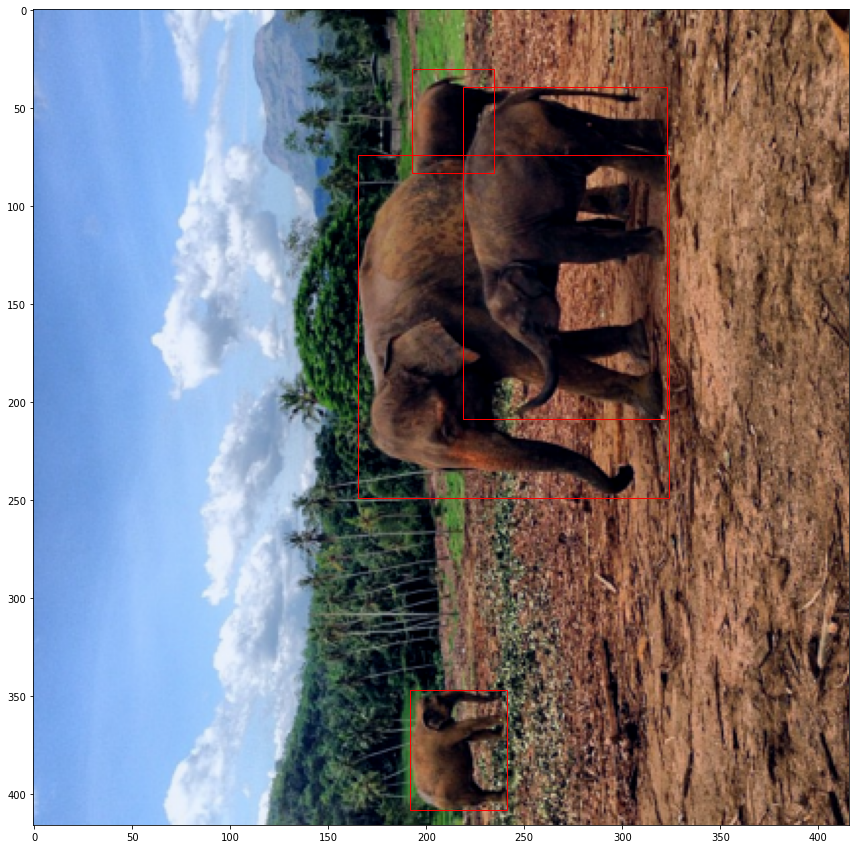

In [34]:
image = 3
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(images.tensors[image].transpose(0, -1).to('cpu').flip(2)/255.+.4)
for box in targets[image].bbox:
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [30]:
predictions, feature_maps = model(images)

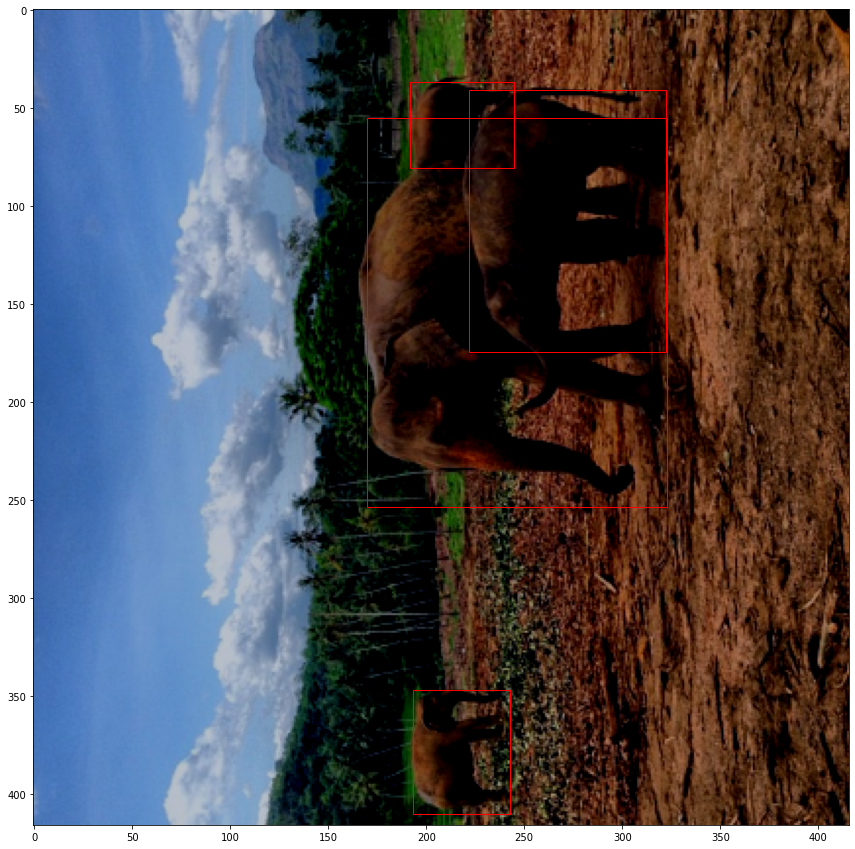

In [36]:
image = 3
threshold = 0.75
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(images.tensors[image].transpose(0, -1).to('cpu').flip(2)/255.+.2)
for box in predictions[image].bbox[torch.where(predictions[image].extra_fields['scores']>threshold)]:
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [306]:
results[2].extra_fields['scores']

tensor([0.4404, 0.3867, 0.3569, 0.3274, 0.3188, 0.2817, 0.2358, 0.2218, 0.1989,
        0.1914, 0.1914, 0.1794, 0.1693, 0.1621, 0.1519, 0.1517, 0.1499, 0.1235,
        0.1088, 0.1044, 0.1040, 0.1011, 0.0946, 0.0927, 0.0902, 0.0845, 0.0842,
        0.0790, 0.0730, 0.0679, 0.0620, 0.0608, 0.0590, 0.0590, 0.0557, 0.0549,
        0.0517, 0.0509, 0.0504, 0.1599, 0.1335, 0.0531, 0.1075, 0.0723, 0.0533,
        0.2871, 0.1057, 0.0587, 0.1644, 0.1177, 0.0604, 0.0947, 0.9897, 0.8179,
        0.6426, 0.4744, 0.4700, 0.3901, 0.2703, 0.1810, 0.1794, 0.1794, 0.1700,
        0.1592, 0.1465, 0.1313, 0.1245, 0.0989, 0.0956, 0.0908, 0.0848, 0.0790,
        0.0772, 0.0723, 0.0653, 0.0646, 0.1432, 0.1187, 0.1099, 0.0723, 0.0558,
        0.0566, 0.0771, 0.0767, 0.0746, 0.0709, 0.1296, 0.0796, 0.0760, 0.0542,
        0.0656, 0.0697], device='cuda:0', grad_fn=<IndexSelectBackward>)

RuntimeError: CUDA error: device-side assert triggered

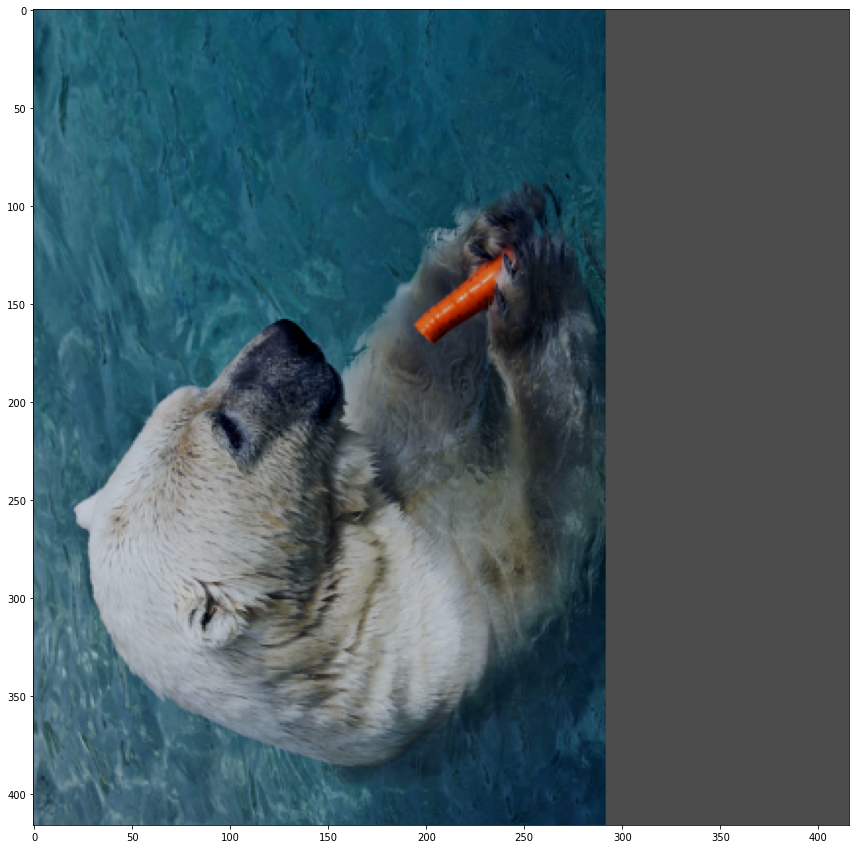

In [310]:
image = 1
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(images.tensors[image].transpose(0, -1).to('cpu').flip(2)/255.+.3)
for box in results[image].bbox[torch.where(results[image].extra_fields['scores']>0.2)]:
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

54.46623093681917